## Cell type annotation by scArches label transfer
Train scArches VAE model sequentially on head and antenna reference datasets and predict cell types labels for w1118_42d and drprnull_42d samples

In [1]:
!python --version

Python 3.12.2


## Load required packages

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os
import plotnine as p
import pickle

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Check GPU availability and configuration

In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

1
True
1
0
Tesla P100-PCIE-12GB


## Set up I/O and read reference and query datasets
Fly cell atlas head and antenna datasets will be used as references, obtained from https://flycellatlas.org/
10x raw H5AD files were downloaded for both head and antenna

In [4]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
referencepath = basepath.joinpath('reference','FCA')
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','scarches')

In [5]:
## Read reference datasets
fca_reference_head = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference_antenna = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_antenna_10x_raw.h5ad"))

fca_reference_head.layers["counts"] = fca_reference_head.X.copy()
fca_reference_antenna.layers["counts"] = fca_reference_antenna.X.copy()

## combine tissue and batch info from each dataset to for unique categorical covariates 
fca_reference_head.obs['tissue'] = "fca_head"
fca_reference_head.obs['tissue_batch'] = fca_reference_head.obs['batch'].astype(str)+"_"+fca_reference_head.obs['tissue'].astype(str)
fca_reference_antenna.obs['tissue'] = "fca_antenna"
fca_reference_antenna.obs['tissue_batch'] = fca_reference_antenna.obs['batch'].astype(str)+"_"+fca_reference_antenna.obs['tissue'].astype(str)


print(fca_reference_head.shape,fca_reference_antenna.shape)

(100527, 13056) (37254, 13203)


In [6]:
## read query datasets
w1118_42d = sc.read_h5ad(inputpath.joinpath("w1118_42d_slim.h5ad"))
w1118_42d.raw = w1118_42d

drprnull_42d = sc.read_h5ad(inputpath.joinpath("drprnull_42d_slim.h5ad"))
drprnull_42d.raw = drprnull_42d

print(w1118_42d.shape,drprnull_42d.shape )

(9033, 16507) (6423, 16507)


In [7]:
## Subset reference datasets to have genes common to query datasets 

common_genes = list(set(w1118_42d.var_names) & set(drprnull_42d.var_names)  & set(fca_reference_head.var_names) & set(fca_reference_antenna.var_names) )
print(len(common_genes))

fca_reference_head = fca_reference_head[:,common_genes ]
fca_reference_head = fca_reference_head.copy()

fca_reference_antenna = fca_reference_antenna[:,common_genes ]
fca_reference_antenna = fca_reference_antenna.copy()

w1118_42d = w1118_42d[:,common_genes]
w1118_42d = w1118_42d.copy()

drprnull_42d = drprnull_42d[:,common_genes]
drprnull_42d = drprnull_42d.copy()

print(fca_reference_antenna.shape,fca_reference_head.shape,w1118_42d.shape,drprnull_42d.shape)

12008
(37254, 12008) (100527, 12008) (9033, 12008) (6423, 12008)


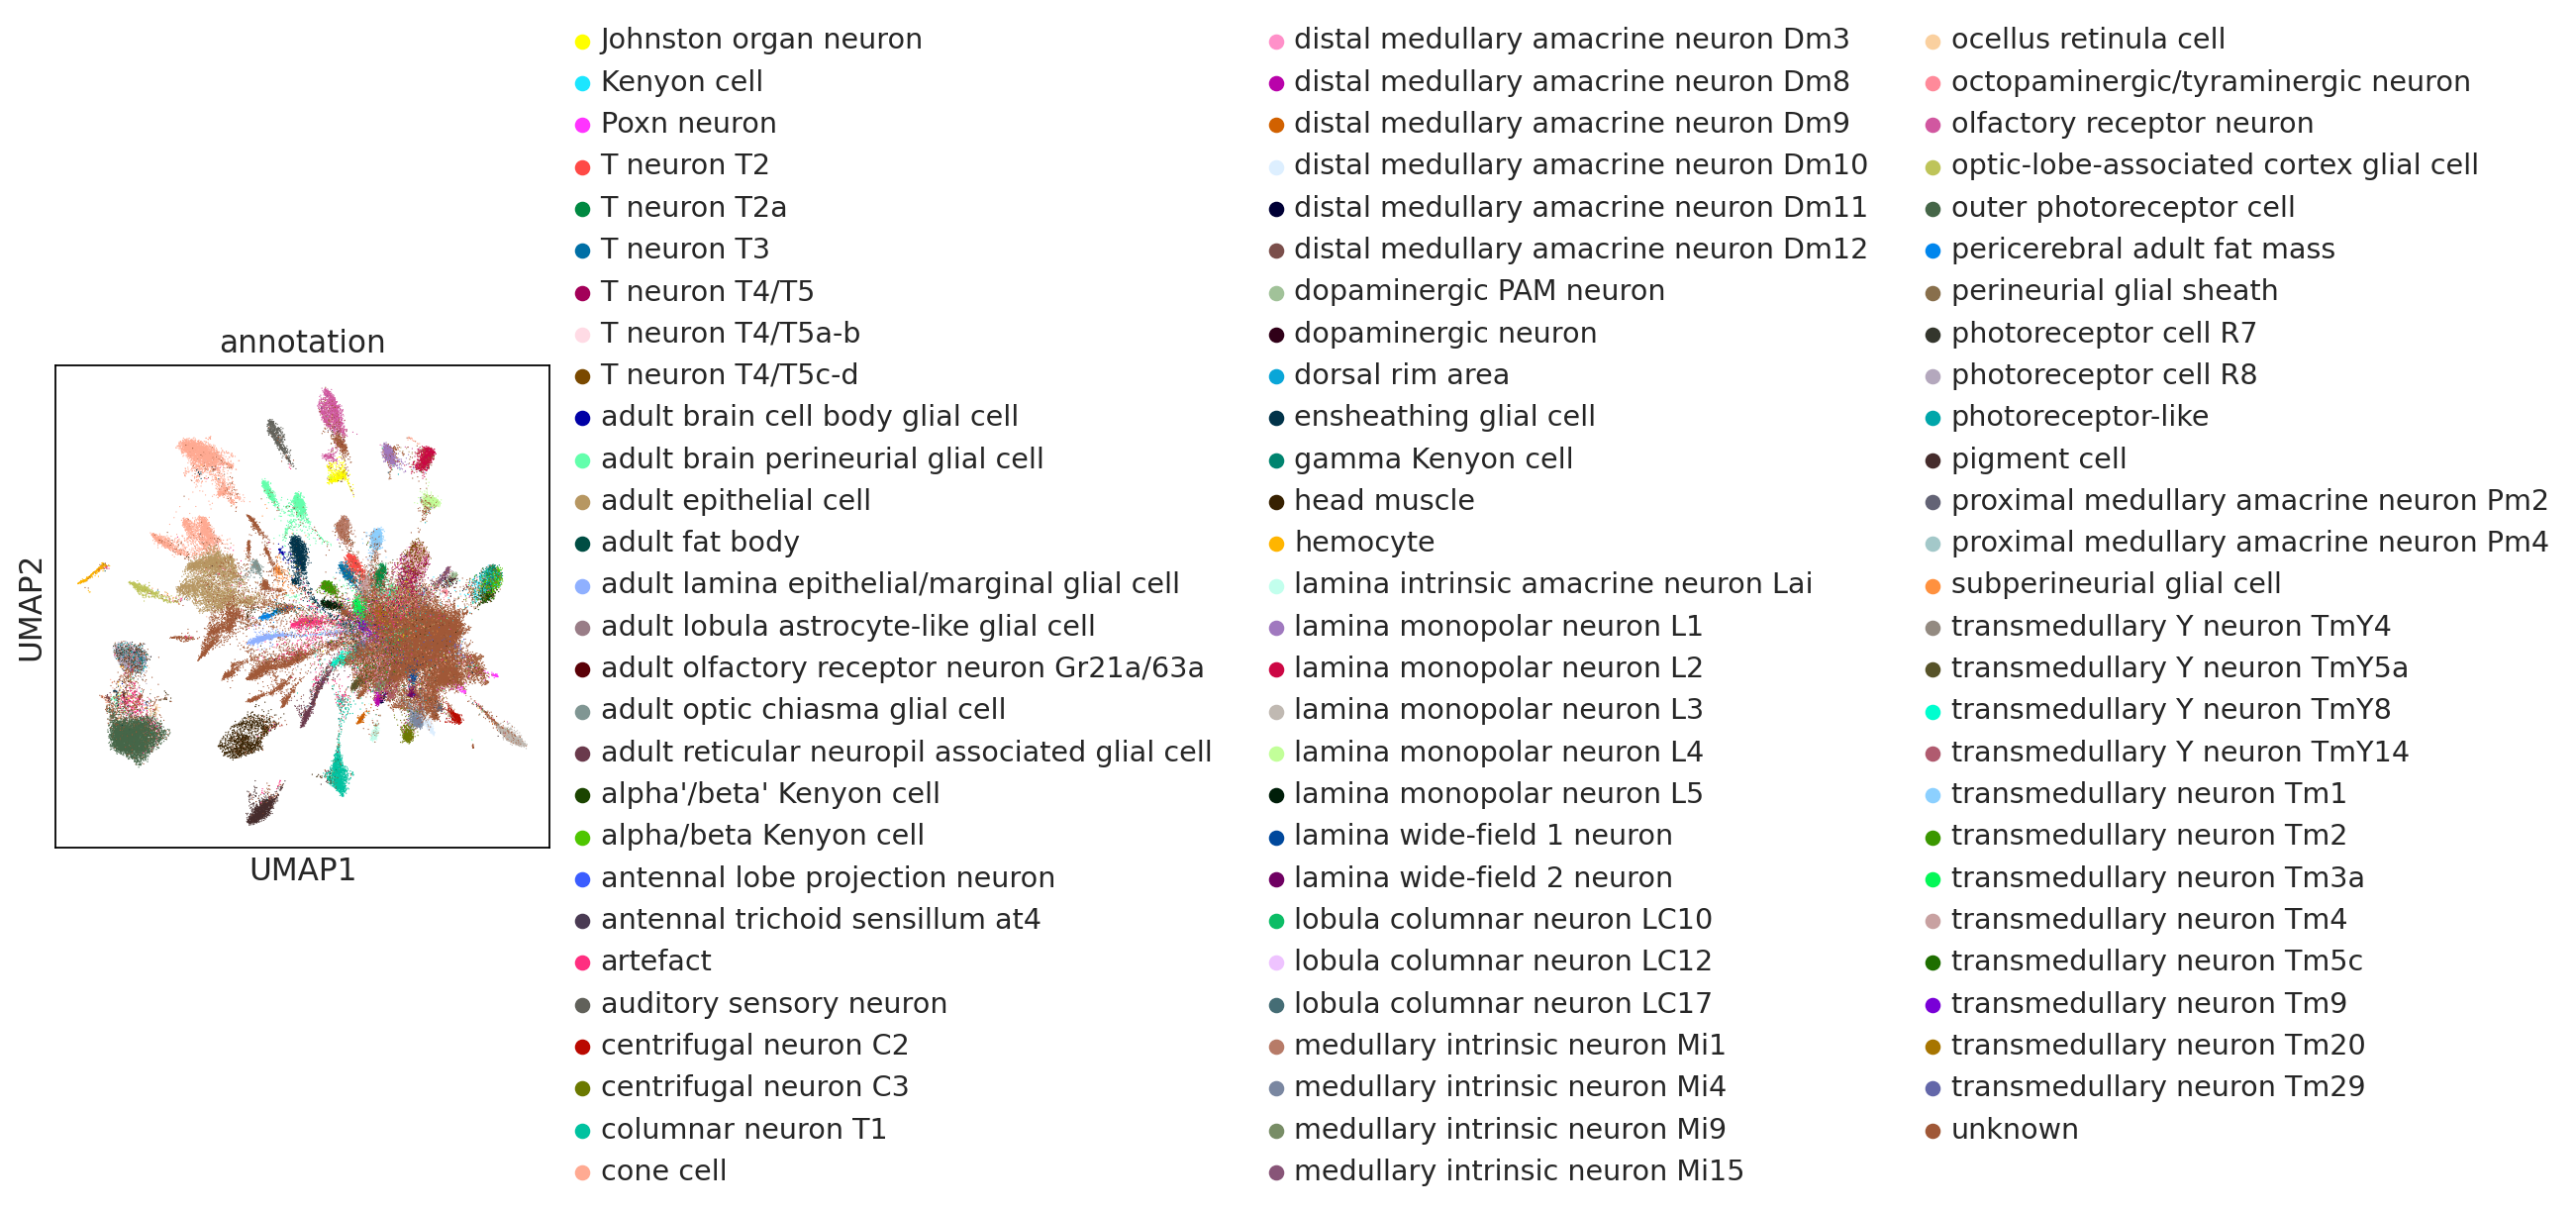

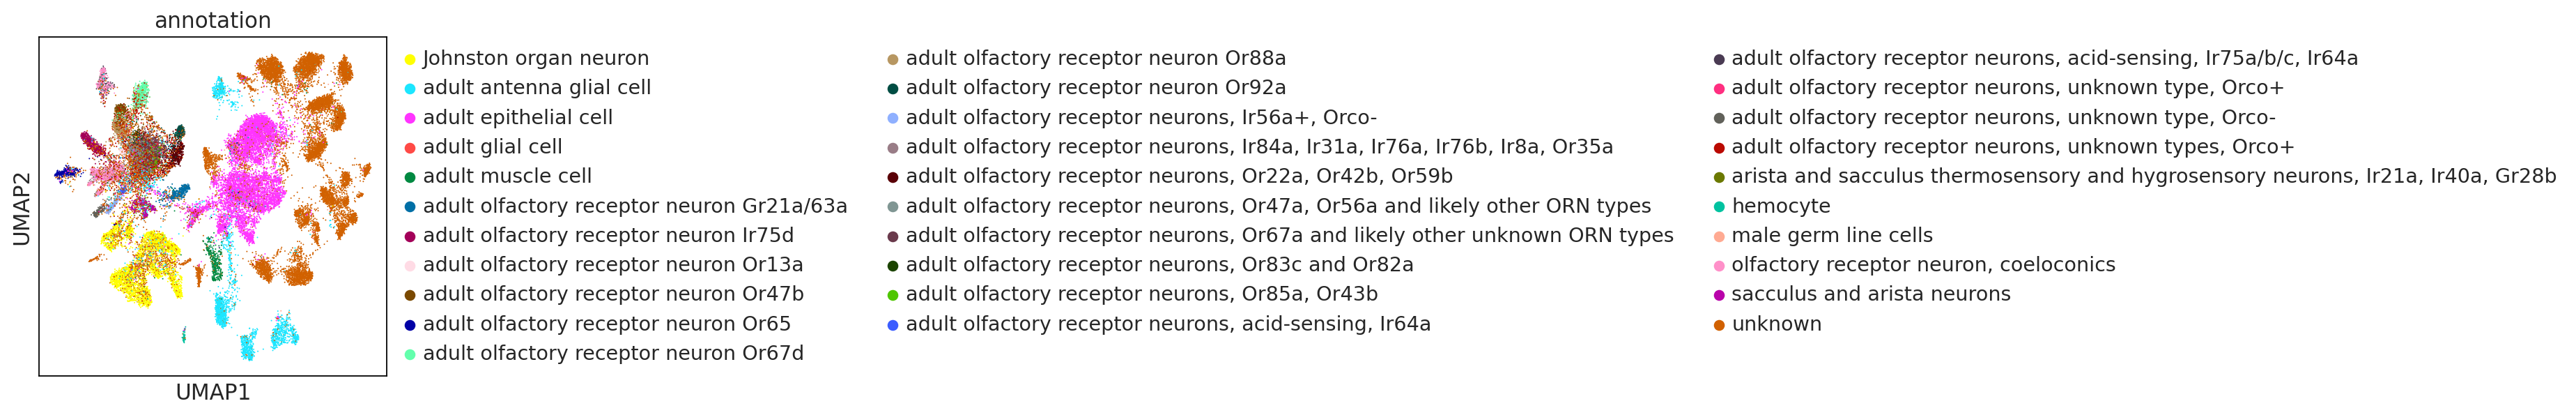

In [8]:
sc.pl.umap(fca_reference_head,color="annotation")
sc.pl.umap(fca_reference_antenna,color="annotation")

## Train model on head reference 

In [9]:
sc.pp.normalize_total(fca_reference_head)
sc.pp.log1p(fca_reference_head)
fca_reference_head.raw = fca_reference_head

sc.pp.highly_variable_genes(
    fca_reference_head,
    n_top_genes=2000,
    batch_key="tissue_batch",
    subset=True)

## sca.models.SCVI.setup_anndata(fca_reference_head, batch_key="tissue_batch",categorical_covariate_keys=["age","fly_genetics","tissue","dissection_lab","sex"])
sca.models.SCVI.setup_anndata(fca_reference_head, batch_key="tissue_batch") ## NotImplementedError: scArches currently does not support models with extra categorical covariates.
head_vae = sca.models.SCVI(
    fca_reference_head,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:22)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


In [10]:
head_vae.train(max_epochs=200, check_val_every_n_epoch = 1)
head_latent = sc.AnnData(head_vae.get_latent_representation())
head_latent.obs["batch"] = fca_reference_head.obs["batch"].tolist()
head_latent.obs["tissue"] = fca_reference_head.obs["tissue"].tolist()
head_latent.obs["tissue_batch"] = fca_reference_head.obs["tissue_batch"].tolist()
head_latent.obs["annotation"] = fca_reference_head.obs["annotation"].tolist()
head_latent.obs["broad_annotation"] = fca_reference_head.obs["broad_annotation"].tolist()
head_latent.obs["broad_annotation_extrapolated"] = fca_reference_head.obs["broad_annotation_extrapolated"].tolist()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 2/200:   0%|          | 1/200 [00:08<29:16,  8.83s/it, v_num=1, train_loss_step=218, train_loss_epoch=235]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 3/200:   1%|          | 2/200 [00:17<28:24,  8.61s/it, v_num=1, train_loss_step=215, train_loss_epoch=217]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 4/200:   2%|▏         | 3/200 [00:25<28:06,  8.56s/it, v_num=1, train_loss_step=210, train_loss_epoch=212]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 5/200:   2%|▏         | 4/200 [00:34<27:56,  8.55s/it, v_num=1, train_loss_step=210, train_loss_epoch=209]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 6/200:   2%|▎         | 5/200 [00:42<27:49,  8.56s/it, v_num=1, train_loss_step=210, train_loss_epoch=207]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 7/200:   3%|▎         | 6/200 [00:51<27:38,  8.55s/it, v_num=1, train_loss_step=210, train_loss_epoch=206]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 8/200:   4%|▎         | 7/200 [01:00<27:32,  8.56s/it, v_num=1, train_loss_step=208, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 9/200:   4%|▍         | 8/200 [01:08<27:28,  8.58s/it, v_num=1, train_loss_step=206, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 10/200:   4%|▍         | 9/200 [01:17<27:17,  8.57s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 11/200:   5%|▌         | 10/200 [01:25<27:03,  8.55s/it, v_num=1, train_loss_step=205, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 12/200:   6%|▌         | 11/200 [01:34<26:55,  8.55s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 13/200:   6%|▌         | 12/200 [01:42<26:46,  8.54s/it, v_num=1, train_loss_step=204, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 14/200:   6%|▋         | 13/200 [01:51<26:29,  8.50s/it, v_num=1, train_loss_step=199, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 15/200:   7%|▋         | 14/200 [01:59<26:17,  8.48s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 16/200:   8%|▊         | 15/200 [02:08<26:09,  8.48s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 17/200:   8%|▊         | 16/200 [02:16<26:05,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 18/200:   8%|▊         | 17/200 [02:25<25:59,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 19/200:   9%|▉         | 18/200 [02:33<25:48,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 20/200:  10%|▉         | 19/200 [02:42<25:38,  8.50s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 21/200:  10%|█         | 20/200 [02:50<25:26,  8.48s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 22/200:  10%|█         | 21/200 [02:59<25:16,  8.47s/it, v_num=1, train_loss_step=198, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 23/200:  11%|█         | 22/200 [03:07<25:06,  8.46s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 24/200:  12%|█▏        | 23/200 [03:16<25:00,  8.48s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 25/200:  12%|█▏        | 24/200 [03:24<24:53,  8.49s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 26/200:  12%|█▎        | 25/200 [03:33<24:49,  8.51s/it, v_num=1, train_loss_step=203, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 27/200:  13%|█▎        | 26/200 [03:41<24:38,  8.50s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 28/200:  14%|█▎        | 27/200 [03:50<24:28,  8.49s/it, v_num=1, train_loss_step=199, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 29/200:  14%|█▍        | 28/200 [03:58<24:19,  8.49s/it, v_num=1, train_loss_step=199, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 30/200:  14%|█▍        | 29/200 [04:06<24:09,  8.48s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 31/200:  15%|█▌        | 30/200 [04:15<24:00,  8.47s/it, v_num=1, train_loss_step=197, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 32/200:  16%|█▌        | 31/200 [04:23<23:49,  8.46s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 33/200:  16%|█▌        | 32/200 [04:32<23:39,  8.45s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 34/200:  16%|█▋        | 33/200 [04:40<23:27,  8.43s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 35/200:  17%|█▋        | 34/200 [04:49<23:18,  8.42s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 36/200:  18%|█▊        | 35/200 [04:57<23:06,  8.41s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 37/200:  18%|█▊        | 36/200 [05:05<22:57,  8.40s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 38/200:  18%|█▊        | 37/200 [05:14<22:51,  8.41s/it, v_num=1, train_loss_step=197, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 39/200:  19%|█▉        | 38/200 [05:22<22:50,  8.46s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 40/200:  20%|█▉        | 39/200 [05:31<22:46,  8.49s/it, v_num=1, train_loss_step=195, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 41/200:  20%|██        | 40/200 [05:39<22:41,  8.51s/it, v_num=1, train_loss_step=198, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 42/200:  20%|██        | 41/200 [05:48<22:30,  8.49s/it, v_num=1, train_loss_step=203, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 43/200:  21%|██        | 42/200 [05:56<22:23,  8.50s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 44/200:  22%|██▏       | 43/200 [06:05<22:15,  8.51s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 45/200:  22%|██▏       | 44/200 [06:13<22:08,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 46/200:  22%|██▎       | 45/200 [06:22<21:57,  8.50s/it, v_num=1, train_loss_step=207, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 47/200:  23%|██▎       | 46/200 [06:30<21:50,  8.51s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 48/200:  24%|██▎       | 47/200 [06:39<21:40,  8.50s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 49/200:  24%|██▍       | 48/200 [06:47<21:32,  8.50s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 50/200:  24%|██▍       | 49/200 [06:56<21:21,  8.49s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 51/200:  25%|██▌       | 50/200 [07:04<21:12,  8.48s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 52/200:  26%|██▌       | 51/200 [07:13<21:02,  8.47s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 53/200:  26%|██▌       | 52/200 [07:21<20:50,  8.45s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 54/200:  26%|██▋       | 53/200 [07:30<20:45,  8.47s/it, v_num=1, train_loss_step=199, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 55/200:  27%|██▋       | 54/200 [07:38<20:36,  8.47s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 56/200:  28%|██▊       | 55/200 [07:47<20:29,  8.48s/it, v_num=1, train_loss_step=206, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 57/200:  28%|██▊       | 56/200 [07:55<20:19,  8.47s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 58/200:  28%|██▊       | 57/200 [08:04<20:09,  8.46s/it, v_num=1, train_loss_step=197, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 59/200:  29%|██▉       | 58/200 [08:12<20:00,  8.46s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 60/200:  30%|██▉       | 59/200 [08:21<19:59,  8.51s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 61/200:  30%|███       | 60/200 [08:29<19:48,  8.49s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 62/200:  30%|███       | 61/200 [08:38<19:37,  8.47s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 63/200:  31%|███       | 62/200 [08:46<19:29,  8.47s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 64/200:  32%|███▏      | 63/200 [08:55<19:20,  8.47s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 65/200:  32%|███▏      | 64/200 [09:03<19:20,  8.53s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 66/200:  32%|███▎      | 65/200 [09:12<19:10,  8.52s/it, v_num=1, train_loss_step=199, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 67/200:  33%|███▎      | 66/200 [09:20<19:01,  8.52s/it, v_num=1, train_loss_step=208, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 68/200:  34%|███▎      | 67/200 [09:29<18:51,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 69/200:  34%|███▍      | 68/200 [09:37<18:40,  8.49s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 70/200:  34%|███▍      | 69/200 [09:46<18:30,  8.48s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 71/200:  35%|███▌      | 70/200 [09:54<18:21,  8.47s/it, v_num=1, train_loss_step=205, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 72/200:  36%|███▌      | 71/200 [10:03<18:14,  8.49s/it, v_num=1, train_loss_step=203, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 73/200:  36%|███▌      | 72/200 [10:11<18:05,  8.48s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 74/200:  36%|███▋      | 73/200 [10:20<17:58,  8.49s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 75/200:  37%|███▋      | 74/200 [10:28<17:49,  8.49s/it, v_num=1, train_loss_step=204, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 76/200:  38%|███▊      | 75/200 [10:36<17:39,  8.48s/it, v_num=1, train_loss_step=200, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 77/200:  38%|███▊      | 76/200 [10:45<17:29,  8.46s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 78/200:  38%|███▊      | 77/200 [10:53<17:20,  8.46s/it, v_num=1, train_loss_step=199, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 79/200:  39%|███▉      | 78/200 [11:02<17:11,  8.46s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 80/200:  40%|███▉      | 79/200 [11:10<17:03,  8.46s/it, v_num=1, train_loss_step=202, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 81/200:  40%|████      | 80/200 [11:19<16:54,  8.45s/it, v_num=1, train_loss_step=198, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 82/200:  40%|████      | 81/200 [11:27<16:45,  8.45s/it, v_num=1, train_loss_step=206, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 83/200:  41%|████      | 82/200 [11:36<16:38,  8.47s/it, v_num=1, train_loss_step=203, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 84/200:  42%|████▏     | 83/200 [11:44<16:29,  8.46s/it, v_num=1, train_loss_step=201, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 85/200:  42%|████▏     | 84/200 [11:53<16:26,  8.50s/it, v_num=1, train_loss_step=203, train_loss_epoch=202]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 86/200:  42%|████▎     | 85/200 [12:01<16:18,  8.51s/it, v_num=1, train_loss_step=205, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 87/200:  43%|████▎     | 86/200 [12:10<16:10,  8.51s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 88/200:  44%|████▎     | 87/200 [12:18<16:04,  8.53s/it, v_num=1, train_loss_step=207, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 89/200:  44%|████▍     | 88/200 [12:27<15:55,  8.54s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 90/200:  44%|████▍     | 89/200 [12:35<15:45,  8.52s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 91/200:  45%|████▌     | 90/200 [12:44<15:37,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 92/200:  46%|████▌     | 91/200 [12:52<15:29,  8.53s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 93/200:  46%|████▌     | 92/200 [13:01<15:19,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 94/200:  46%|████▋     | 93/200 [13:09<15:09,  8.50s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 95/200:  47%|████▋     | 94/200 [13:18<15:00,  8.49s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 96/200:  48%|████▊     | 95/200 [13:26<14:51,  8.49s/it, v_num=1, train_loss_step=199, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 97/200:  48%|████▊     | 96/200 [13:35<14:45,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 98/200:  48%|████▊     | 97/200 [13:43<14:38,  8.53s/it, v_num=1, train_loss_step=206, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 99/200:  49%|████▉     | 98/200 [13:52<14:30,  8.53s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 100/200:  50%|████▉     | 99/200 [14:01<14:21,  8.53s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 101/200:  50%|█████     | 100/200 [14:09<14:12,  8.52s/it, v_num=1, train_loss_step=200, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 102/200:  50%|█████     | 101/200 [14:18<14:03,  8.52s/it, v_num=1, train_loss_step=208, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 103/200:  51%|█████     | 102/200 [14:26<13:54,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 104/200:  52%|█████▏    | 103/200 [14:35<13:45,  8.51s/it, v_num=1, train_loss_step=206, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 105/200:  52%|█████▏    | 104/200 [14:43<13:37,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 106/200:  52%|█████▎    | 105/200 [14:52<13:28,  8.51s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 107/200:  53%|█████▎    | 106/200 [15:00<13:20,  8.51s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 108/200:  54%|█████▎    | 107/200 [15:09<13:11,  8.51s/it, v_num=1, train_loss_step=206, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 109/200:  54%|█████▍    | 108/200 [15:17<13:03,  8.52s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 110/200:  55%|█████▍    | 109/200 [15:26<12:55,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 111/200:  55%|█████▌    | 110/200 [15:34<12:47,  8.53s/it, v_num=1, train_loss_step=205, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 112/200:  56%|█████▌    | 111/200 [15:43<12:39,  8.53s/it, v_num=1, train_loss_step=204, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 113/200:  56%|█████▌    | 112/200 [15:51<12:29,  8.51s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 114/200:  56%|█████▋    | 113/200 [16:00<12:19,  8.50s/it, v_num=1, train_loss_step=207, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 115/200:  57%|█████▋    | 114/200 [16:08<12:10,  8.49s/it, v_num=1, train_loss_step=206, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 116/200:  57%|█████▊    | 115/200 [16:17<12:02,  8.50s/it, v_num=1, train_loss_step=207, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 117/200:  58%|█████▊    | 116/200 [16:25<11:53,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 118/200:  58%|█████▊    | 117/200 [16:34<11:44,  8.49s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 119/200:  59%|█████▉    | 118/200 [16:42<11:34,  8.47s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 120/200:  60%|█████▉    | 119/200 [16:50<11:23,  8.44s/it, v_num=1, train_loss_step=205, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 121/200:  60%|██████    | 120/200 [16:59<11:16,  8.45s/it, v_num=1, train_loss_step=206, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 122/200:  60%|██████    | 121/200 [17:08<11:18,  8.59s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 123/200:  61%|██████    | 122/200 [17:17<11:26,  8.81s/it, v_num=1, train_loss_step=201, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 124/200:  62%|██████▏   | 123/200 [17:27<11:31,  8.98s/it, v_num=1, train_loss_step=207, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 125/200:  62%|██████▏   | 124/200 [17:36<11:31,  9.10s/it, v_num=1, train_loss_step=205, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 126/200:  62%|██████▎   | 125/200 [17:45<11:27,  9.17s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 127/200:  63%|██████▎   | 126/200 [17:55<11:22,  9.22s/it, v_num=1, train_loss_step=203, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 128/200:  64%|██████▎   | 127/200 [18:04<11:10,  9.19s/it, v_num=1, train_loss_step=199, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 129/200:  64%|██████▍   | 128/200 [18:13<11:03,  9.22s/it, v_num=1, train_loss_step=204, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 130/200:  64%|██████▍   | 129/200 [18:22<10:59,  9.29s/it, v_num=1, train_loss_step=202, train_loss_epoch=203]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 131/200:  65%|██████▌   | 130/200 [18:32<10:47,  9.25s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 132/200:  66%|██████▌   | 131/200 [18:41<10:32,  9.17s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 133/200:  66%|██████▌   | 132/200 [18:50<10:23,  9.17s/it, v_num=1, train_loss_step=201, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 134/200:  66%|██████▋   | 133/200 [18:59<10:14,  9.17s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 135/200:  67%|██████▋   | 134/200 [19:08<10:07,  9.21s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 136/200:  68%|██████▊   | 135/200 [19:18<10:03,  9.28s/it, v_num=1, train_loss_step=200, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 137/200:  68%|██████▊   | 136/200 [19:27<09:52,  9.26s/it, v_num=1, train_loss_step=201, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 138/200:  68%|██████▊   | 137/200 [19:36<09:35,  9.13s/it, v_num=1, train_loss_step=207, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 139/200:  69%|██████▉   | 138/200 [19:44<09:14,  8.94s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 140/200:  70%|██████▉   | 139/200 [19:53<08:56,  8.80s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 141/200:  70%|███████   | 140/200 [20:01<08:41,  8.70s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 142/200:  70%|███████   | 141/200 [20:10<08:29,  8.63s/it, v_num=1, train_loss_step=198, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 143/200:  71%|███████   | 142/200 [20:18<08:20,  8.62s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 144/200:  72%|███████▏  | 143/200 [20:27<08:10,  8.60s/it, v_num=1, train_loss_step=201, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 145/200:  72%|███████▏  | 144/200 [20:35<07:59,  8.57s/it, v_num=1, train_loss_step=200, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 146/200:  72%|███████▎  | 145/200 [20:44<07:49,  8.54s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 147/200:  73%|███████▎  | 146/200 [20:52<07:40,  8.53s/it, v_num=1, train_loss_step=206, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 148/200:  74%|███████▎  | 147/200 [21:01<07:31,  8.51s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 149/200:  74%|███████▍  | 148/200 [21:09<07:22,  8.50s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 150/200:  74%|███████▍  | 149/200 [21:18<07:14,  8.53s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 151/200:  75%|███████▌  | 150/200 [21:26<07:05,  8.52s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 152/200:  76%|███████▌  | 151/200 [21:35<06:56,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 153/200:  76%|███████▌  | 152/200 [21:43<06:47,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 154/200:  76%|███████▋  | 153/200 [21:52<06:39,  8.50s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 155/200:  77%|███████▋  | 154/200 [22:00<06:30,  8.50s/it, v_num=1, train_loss_step=206, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 156/200:  78%|███████▊  | 155/200 [22:09<06:22,  8.49s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 157/200:  78%|███████▊  | 156/200 [22:17<06:15,  8.53s/it, v_num=1, train_loss_step=206, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 158/200:  78%|███████▊  | 157/200 [22:26<06:08,  8.56s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 159/200:  79%|███████▉  | 158/200 [22:34<05:58,  8.53s/it, v_num=1, train_loss_step=201, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 160/200:  80%|███████▉  | 159/200 [22:43<05:49,  8.52s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 161/200:  80%|████████  | 160/200 [22:51<05:40,  8.50s/it, v_num=1, train_loss_step=200, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 162/200:  80%|████████  | 161/200 [23:00<05:31,  8.49s/it, v_num=1, train_loss_step=202, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 163/200:  81%|████████  | 162/200 [23:08<05:23,  8.52s/it, v_num=1, train_loss_step=201, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 164/200:  82%|████████▏ | 163/200 [23:17<05:16,  8.54s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 165/200:  82%|████████▏ | 164/200 [23:25<05:06,  8.51s/it, v_num=1, train_loss_step=208, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 166/200:  82%|████████▎ | 165/200 [23:34<04:57,  8.51s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 167/200:  83%|████████▎ | 166/200 [23:42<04:48,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 168/200:  84%|████████▎ | 167/200 [23:51<04:40,  8.50s/it, v_num=1, train_loss_step=200, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 169/200:  84%|████████▍ | 168/200 [23:59<04:31,  8.49s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 170/200:  84%|████████▍ | 169/200 [24:08<04:22,  8.48s/it, v_num=1, train_loss_step=206, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 171/200:  85%|████████▌ | 170/200 [24:16<04:15,  8.51s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 172/200:  86%|████████▌ | 171/200 [24:25<04:06,  8.51s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 173/200:  86%|████████▌ | 172/200 [24:33<03:58,  8.51s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 174/200:  86%|████████▋ | 173/200 [24:42<03:49,  8.51s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 175/200:  87%|████████▋ | 174/200 [24:50<03:40,  8.50s/it, v_num=1, train_loss_step=205, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 176/200:  88%|████████▊ | 175/200 [24:59<03:32,  8.50s/it, v_num=1, train_loss_step=207, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 177/200:  88%|████████▊ | 176/200 [25:07<03:24,  8.51s/it, v_num=1, train_loss_step=200, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 178/200:  88%|████████▊ | 177/200 [25:16<03:15,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 179/200:  89%|████████▉ | 178/200 [25:24<03:07,  8.50s/it, v_num=1, train_loss_step=203, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 180/200:  90%|████████▉ | 179/200 [25:33<02:58,  8.50s/it, v_num=1, train_loss_step=204, train_loss_epoch=204]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 181/200:  90%|█████████ | 180/200 [25:42<02:50,  8.51s/it, v_num=1, train_loss_step=204, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 182/200:  90%|█████████ | 181/200 [25:50<02:41,  8.51s/it, v_num=1, train_loss_step=207, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 183/200:  91%|█████████ | 182/200 [25:59<02:33,  8.52s/it, v_num=1, train_loss_step=202, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 184/200:  92%|█████████▏| 183/200 [26:07<02:25,  8.53s/it, v_num=1, train_loss_step=205, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 185/200:  92%|█████████▏| 184/200 [26:16<02:16,  8.53s/it, v_num=1, train_loss_step=204, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 186/200:  92%|█████████▎| 185/200 [26:24<02:08,  8.58s/it, v_num=1, train_loss_step=207, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 187/200:  93%|█████████▎| 186/200 [26:33<02:00,  8.59s/it, v_num=1, train_loss_step=205, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 188/200:  94%|█████████▎| 187/200 [26:41<01:51,  8.57s/it, v_num=1, train_loss_step=203, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 189/200:  94%|█████████▍| 188/200 [26:50<01:42,  8.55s/it, v_num=1, train_loss_step=203, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 190/200:  94%|█████████▍| 189/200 [26:58<01:33,  8.53s/it, v_num=1, train_loss_step=206, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 191/200:  95%|█████████▌| 190/200 [27:07<01:25,  8.52s/it, v_num=1, train_loss_step=203, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 192/200:  96%|█████████▌| 191/200 [27:15<01:16,  8.52s/it, v_num=1, train_loss_step=204, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 193/200:  96%|█████████▌| 192/200 [27:24<01:08,  8.55s/it, v_num=1, train_loss_step=207, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 194/200:  96%|█████████▋| 193/200 [27:33<00:59,  8.56s/it, v_num=1, train_loss_step=208, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 195/200:  97%|█████████▋| 194/200 [27:41<00:51,  8.56s/it, v_num=1, train_loss_step=204, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 196/200:  98%|█████████▊| 195/200 [27:50<00:42,  8.56s/it, v_num=1, train_loss_step=204, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 197/200:  98%|█████████▊| 196/200 [27:58<00:34,  8.56s/it, v_num=1, train_loss_step=206, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 198/200:  98%|█████████▊| 197/200 [28:07<00:25,  8.57s/it, v_num=1, train_loss_step=206, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 199/200:  99%|█████████▉| 198/200 [28:15<00:17,  8.56s/it, v_num=1, train_loss_step=207, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|█████████▉| 199/200 [28:24<00:08,  8.55s/it, v_num=1, train_loss_step=205, train_loss_epoch=205]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|██████████| 200/200 [28:33<00:00,  8.56s/it, v_num=1, train_loss_step=205, train_loss_epoch=205]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [28:33<00:00,  8.57s/it, v_num=1, train_loss_step=205, train_loss_epoch=205]


In [11]:
print(head_vae)
sc.pp.neighbors(head_latent, n_neighbors=8)
sc.tl.leiden(head_latent)
sc.tl.umap(head_latent)

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
running Leiden clustering


/scratch/6008451.1.p100/ipykernel_66878/2447297397.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


    finished: found 42 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:22)


/scratch/6008451.1.p100/ipykernel_66878/3394256085.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


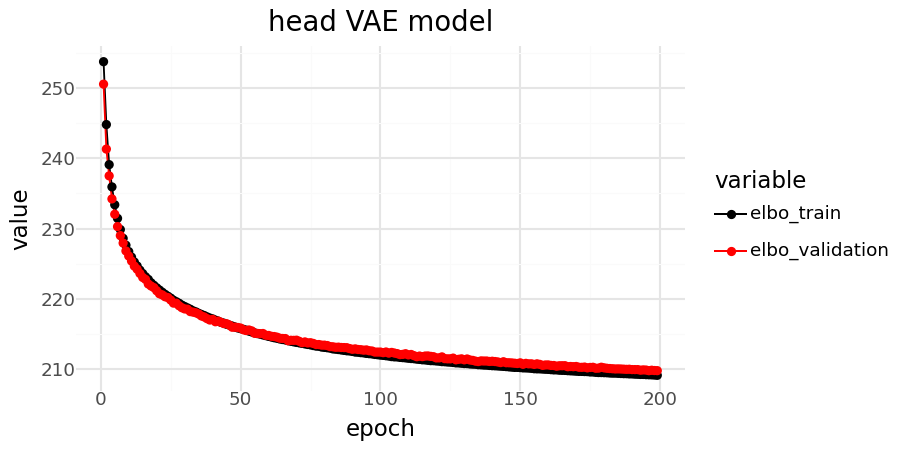

In [12]:
history_df = (
    head_vae.history['elbo_train'].astype(float)
    .join(head_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head VAE model")
    + p.theme_minimal()
)


print(p_)

## Save the trained head model

In [13]:
head_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_model/"
head_vae.save(head_model, overwrite=True)
head_latent.write(head_model+'reference_latent.h5ad')

## Construct tree hierarchy for head model

In [14]:
head_latent.obs['broad_annotation_tissue'] = np.char.add(np.char.add(np.array(head_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue'], dtype=str))
head_latent.obs['annotation_tissue'] = np.char.add(np.char.add(np.array(head_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue'], dtype=str))

head_latent.obs['broad_annotation_tissue_batch'] = np.char.add(np.char.add(np.array(head_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue_batch'], dtype=str))
head_latent.obs['annotation_tissue_batch'] = np.char.add(np.char.add(np.array(head_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue_batch'], dtype=str))

In [15]:
head_latent.obs

batch    tissue tissue_batch                  annotation  \
0          0  fca_head   0_fca_head                     unknown   
1          0  fca_head   0_fca_head                     unknown   
2          0  fca_head   0_fca_head  lamina wide-field 2 neuron   
3          0  fca_head   0_fca_head                     unknown   
4          0  fca_head   0_fca_head              T neuron T4/T5   
...      ...       ...          ...                         ...   
100522    12  fca_head  12_fca_head       adult epithelial cell   
100523    12  fca_head  12_fca_head      ensheathing glial cell   
100524    12  fca_head  12_fca_head                   cone cell   
100525    12  fca_head  12_fca_head                pigment cell   
100526    12  fca_head  12_fca_head  lamina monopolar neuron L1   

          broad_annotation broad_annotation_extrapolated leiden  \
0                  unknown                       unknown      0   
1                  unknown                       unknown      0   
2                   neuron                        neuron      3   
3                  unknown                       unknown      8   
4                   neuron                        neuron     10   
...                    ...                           ...    ...   
100522     epithelial cell               epithelial cell      4   
100523          glial cell                    glial cell     14   
100524  sensory organ cell               epithelial cell      4   
100525        pigment cell            sensory organ cell      5   
100526              neuron                        neuron     26   

            broad_annotation_tissue                    annotation_tissue  \
0                  unknown-fca_head                     unknown-fca_head   
1                  unknown-fca_head                     unknown-fca_head   
2                   neuron-fca_head  lamina wide-field 2 neuron-fca_head   
3                  unknown-fca_head                     unknown-fca_head   
4                   neuron-fca_head              T neuron T4/T5-fca_head   
...                             ...                                  ...   
100522     epithelial cell-fca_head       adult epithelial cell-fca_head   
100523          glial cell-fca_head      ensheathing glial cell-fca_head   
100524  sensory organ cell-fca_head                   cone cell-fca_head   
100525        pigment cell-fca_head                pigment cell-fca_head   
100526              neuron-fca_head  lamina monopolar neuron L1-fca_head   

         broad_annotation_tissue_batch                 annotation_tissue_batch  
0                   unknown-0_fca_head                      unknown-0_fca_head  
1                   unknown-0_fca_head                      unknown-0_fca_head  
2                    neuron-0_fca_head   lamina wide-field 2 neuron-0_fca_head  
3                   unknown-0_fca_head                      unknown-0_fca_head  
4                    neuron-0_fca_head               T neuron T4/T5-0_fca_head  
...                                ...                                     ...  
100522     epithelial cell-12_fca_head       adult epithelial cell-12_fca_head  
100523          glial cell-12_fca_head      ensheathing glial cell-12_fca_head  
100524  sensory organ cell-12_fca_head                   cone cell-12_fca_head  
100525        pigment cell-12_fca_head                pigment cell-12_fca_head  
100526              neuron-12_fca_head  lamina monopolar neuron L1-12_fca_head  

[100527 rows x 11 columns]

In [16]:
head_latent.obs['broad_annotation_tissue'] = head_latent.obs['broad_annotation_tissue'].astype('category')
head_latent.obs['annotation_tissue'] = head_latent.obs['annotation_tissue'].astype('category')
head_latent.obs['broad_annotation_tissue_batch'] = head_latent.obs['broad_annotation_tissue_batch'].astype('category')
head_latent.obs['annotation_tissue_batch'] = head_latent.obs['annotation_tissue_batch'].astype('category')

Starting tree:


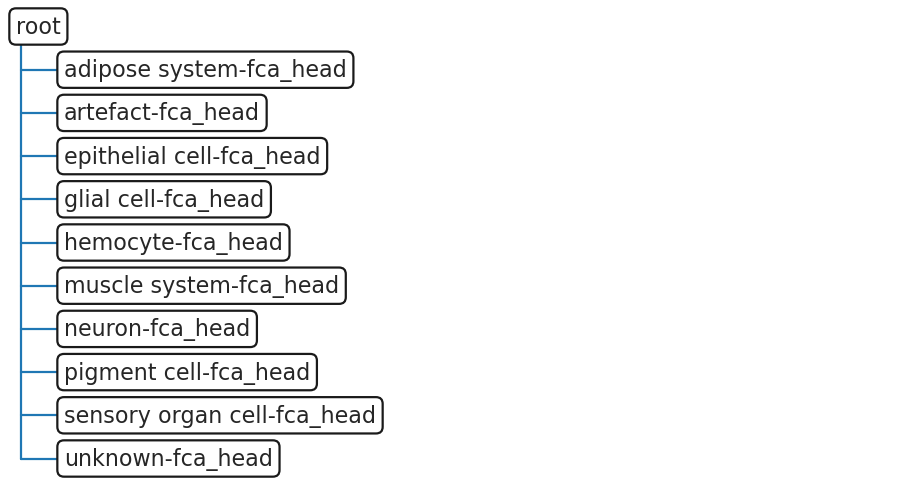

In [17]:
tissueorder = head_latent.obs.tissue.unique().tolist()
tree_head_broadannotation_tissue, mp_head_broadannotation_tissue = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='broad_annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

Starting tree:


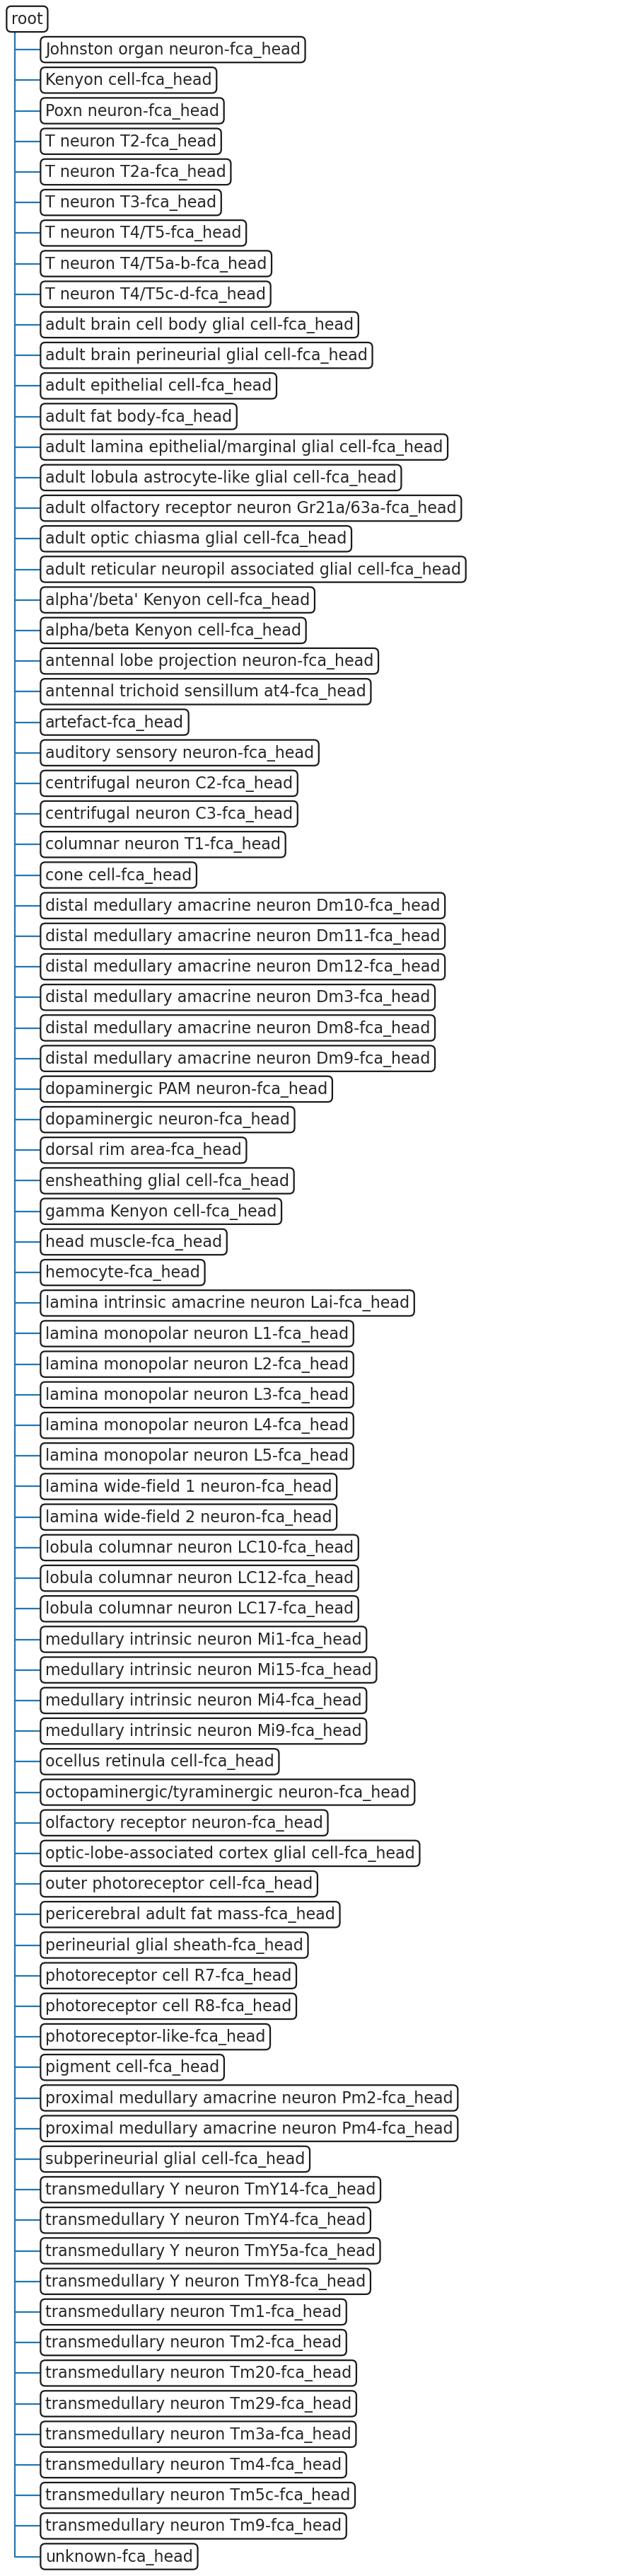

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.


In [18]:
tree_head_fullannotation_tissue, mp_head_fullannotation_tissue = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

Starting tree:


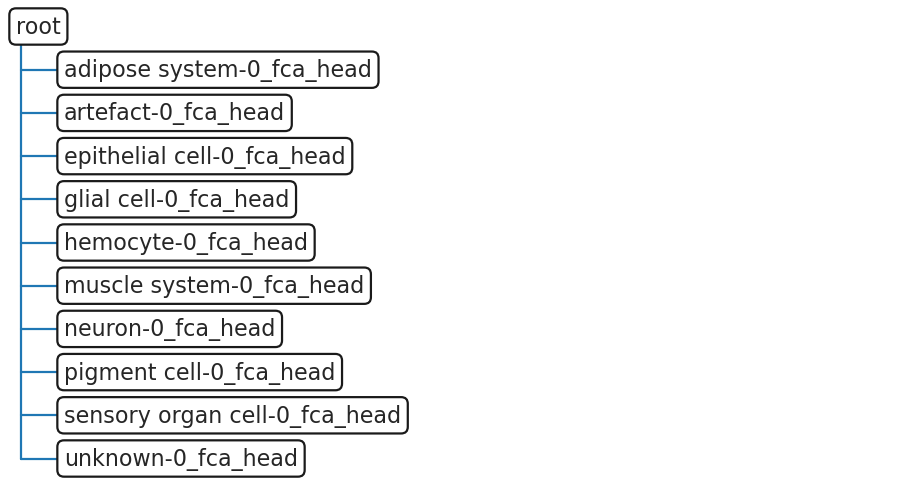


Adding dataset 1_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c


Updated tree:


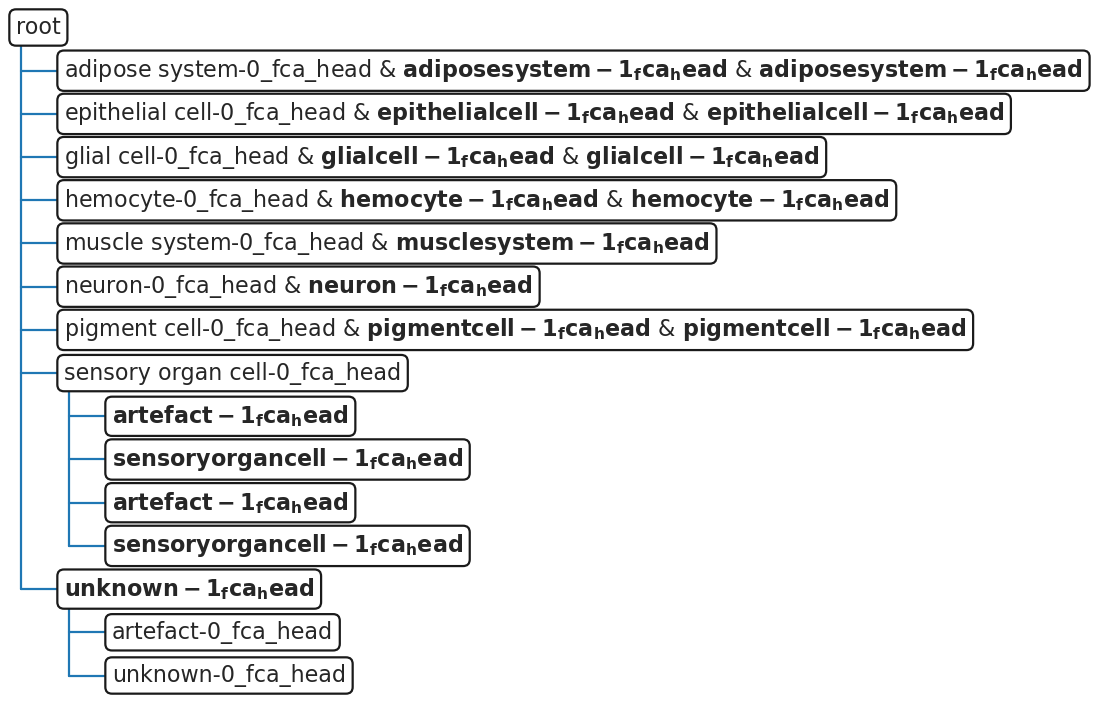


Adding dataset 2_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c

These populations are missing from the tree: 
['artefact-2_fca_head' 'unknown-2_fca_head']

Updated tree:


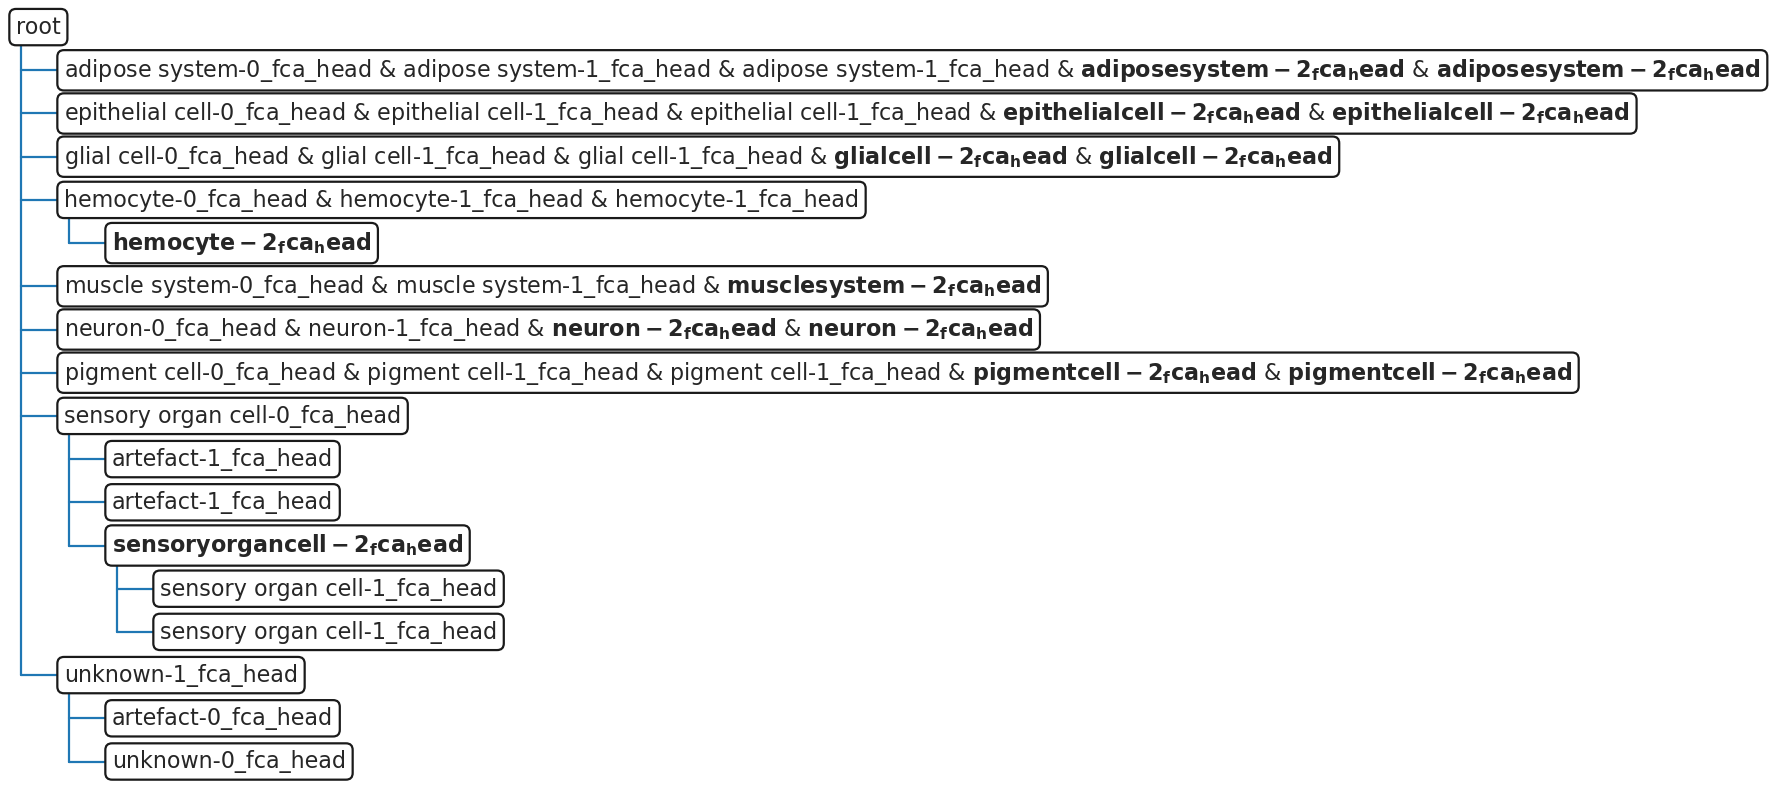


Adding dataset 3_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c


Updated tree:


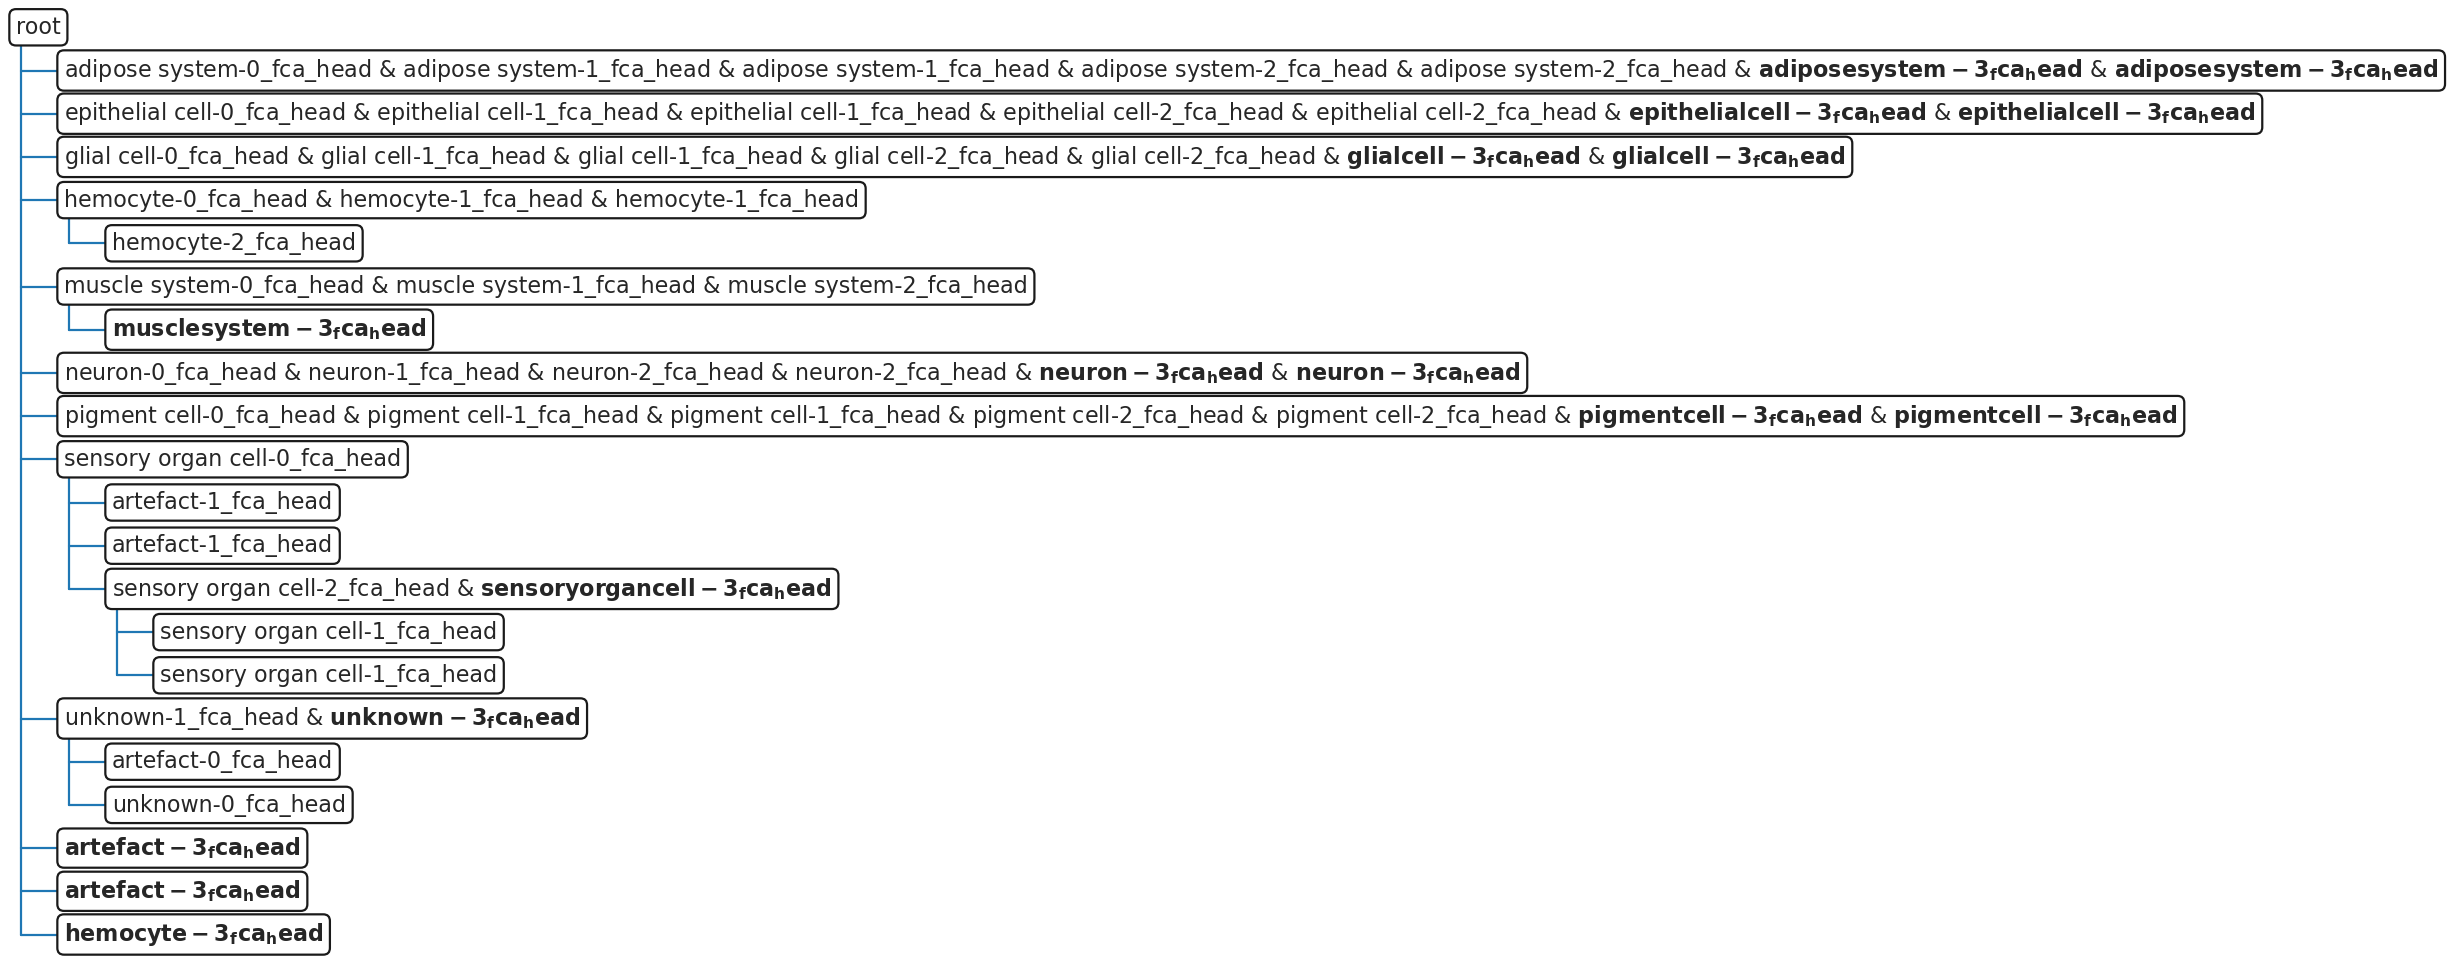


Adding dataset 4_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c


Updated tree:


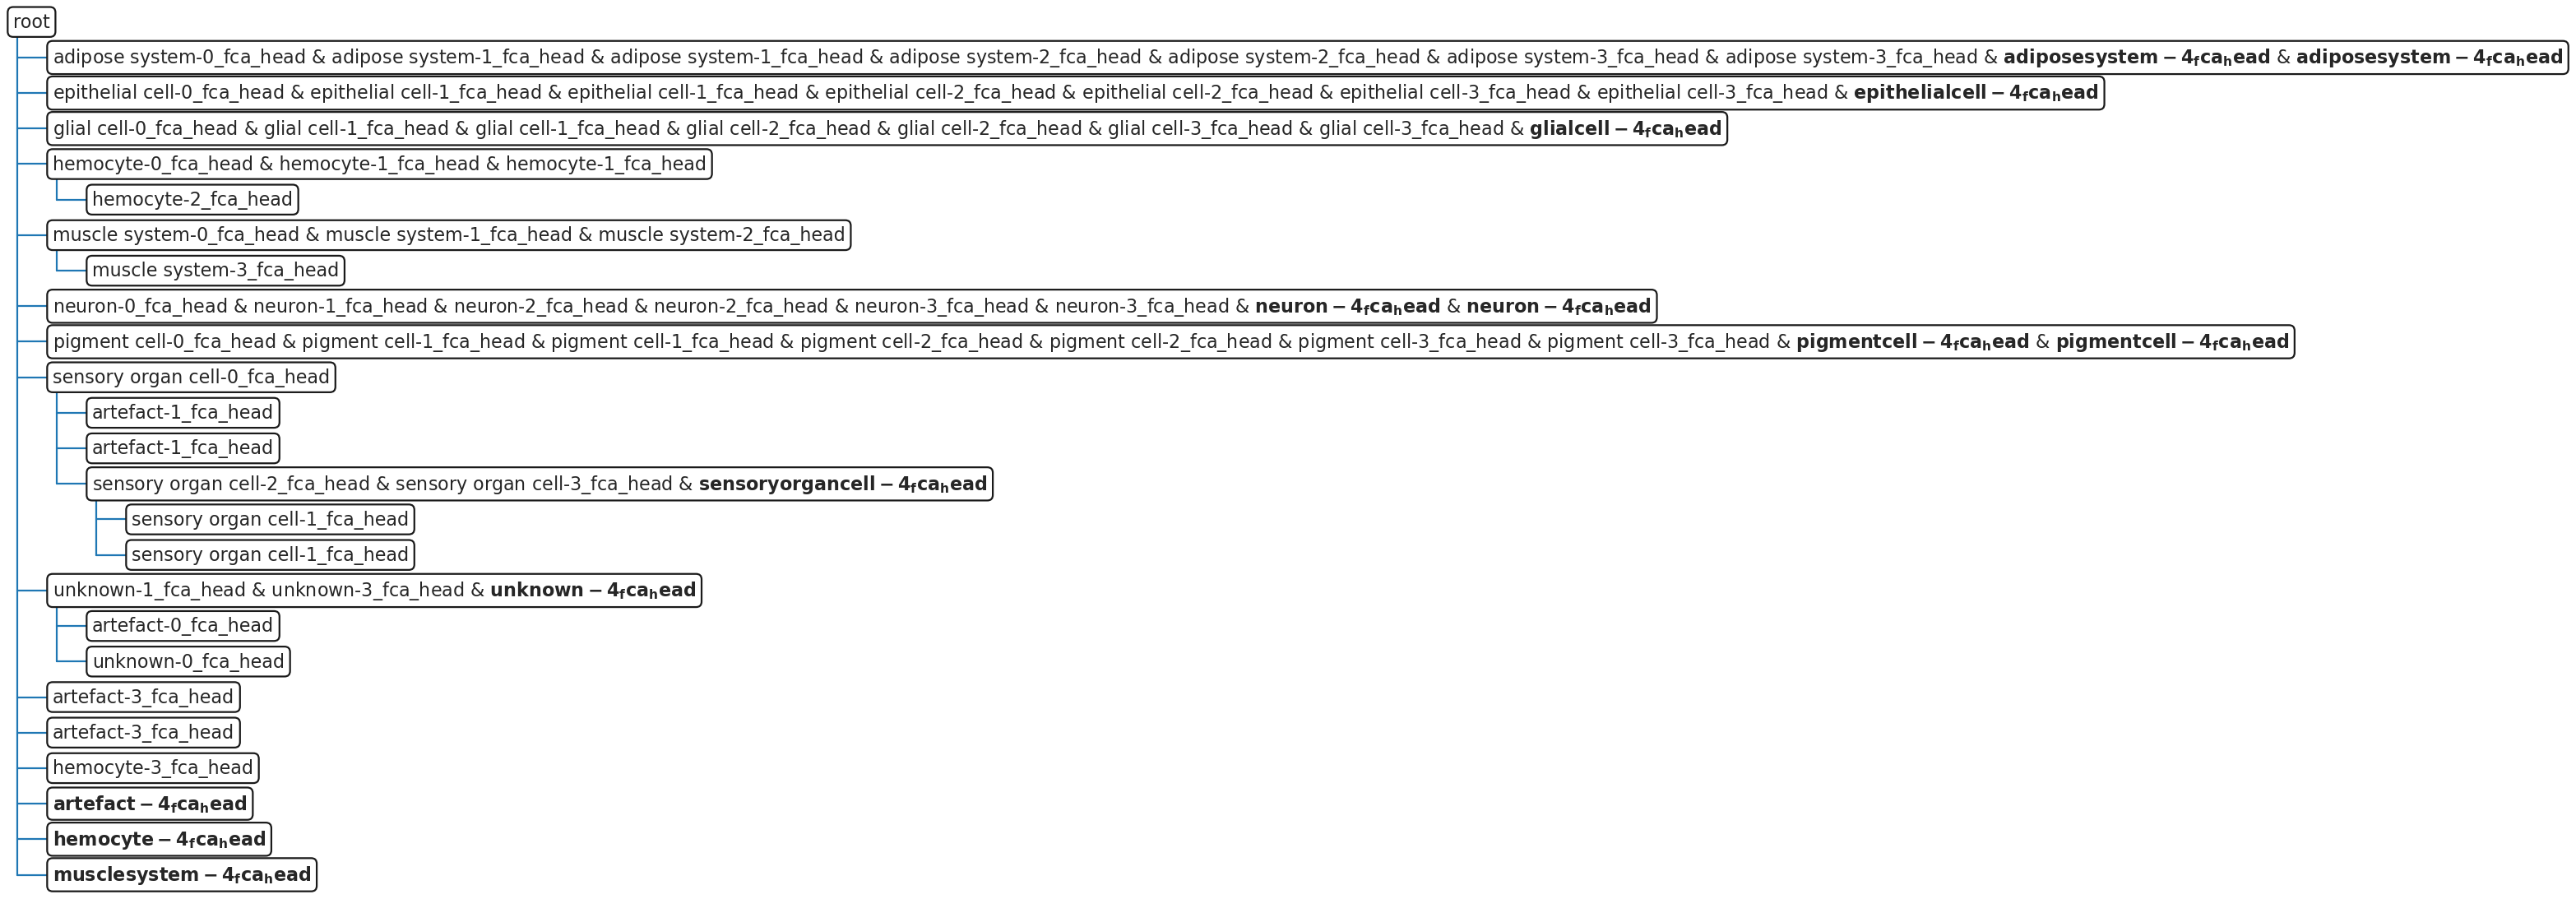


Adding dataset 5_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c

These populations are missing from the tree: 
['artefact-5_fca_head']

Updated tree:


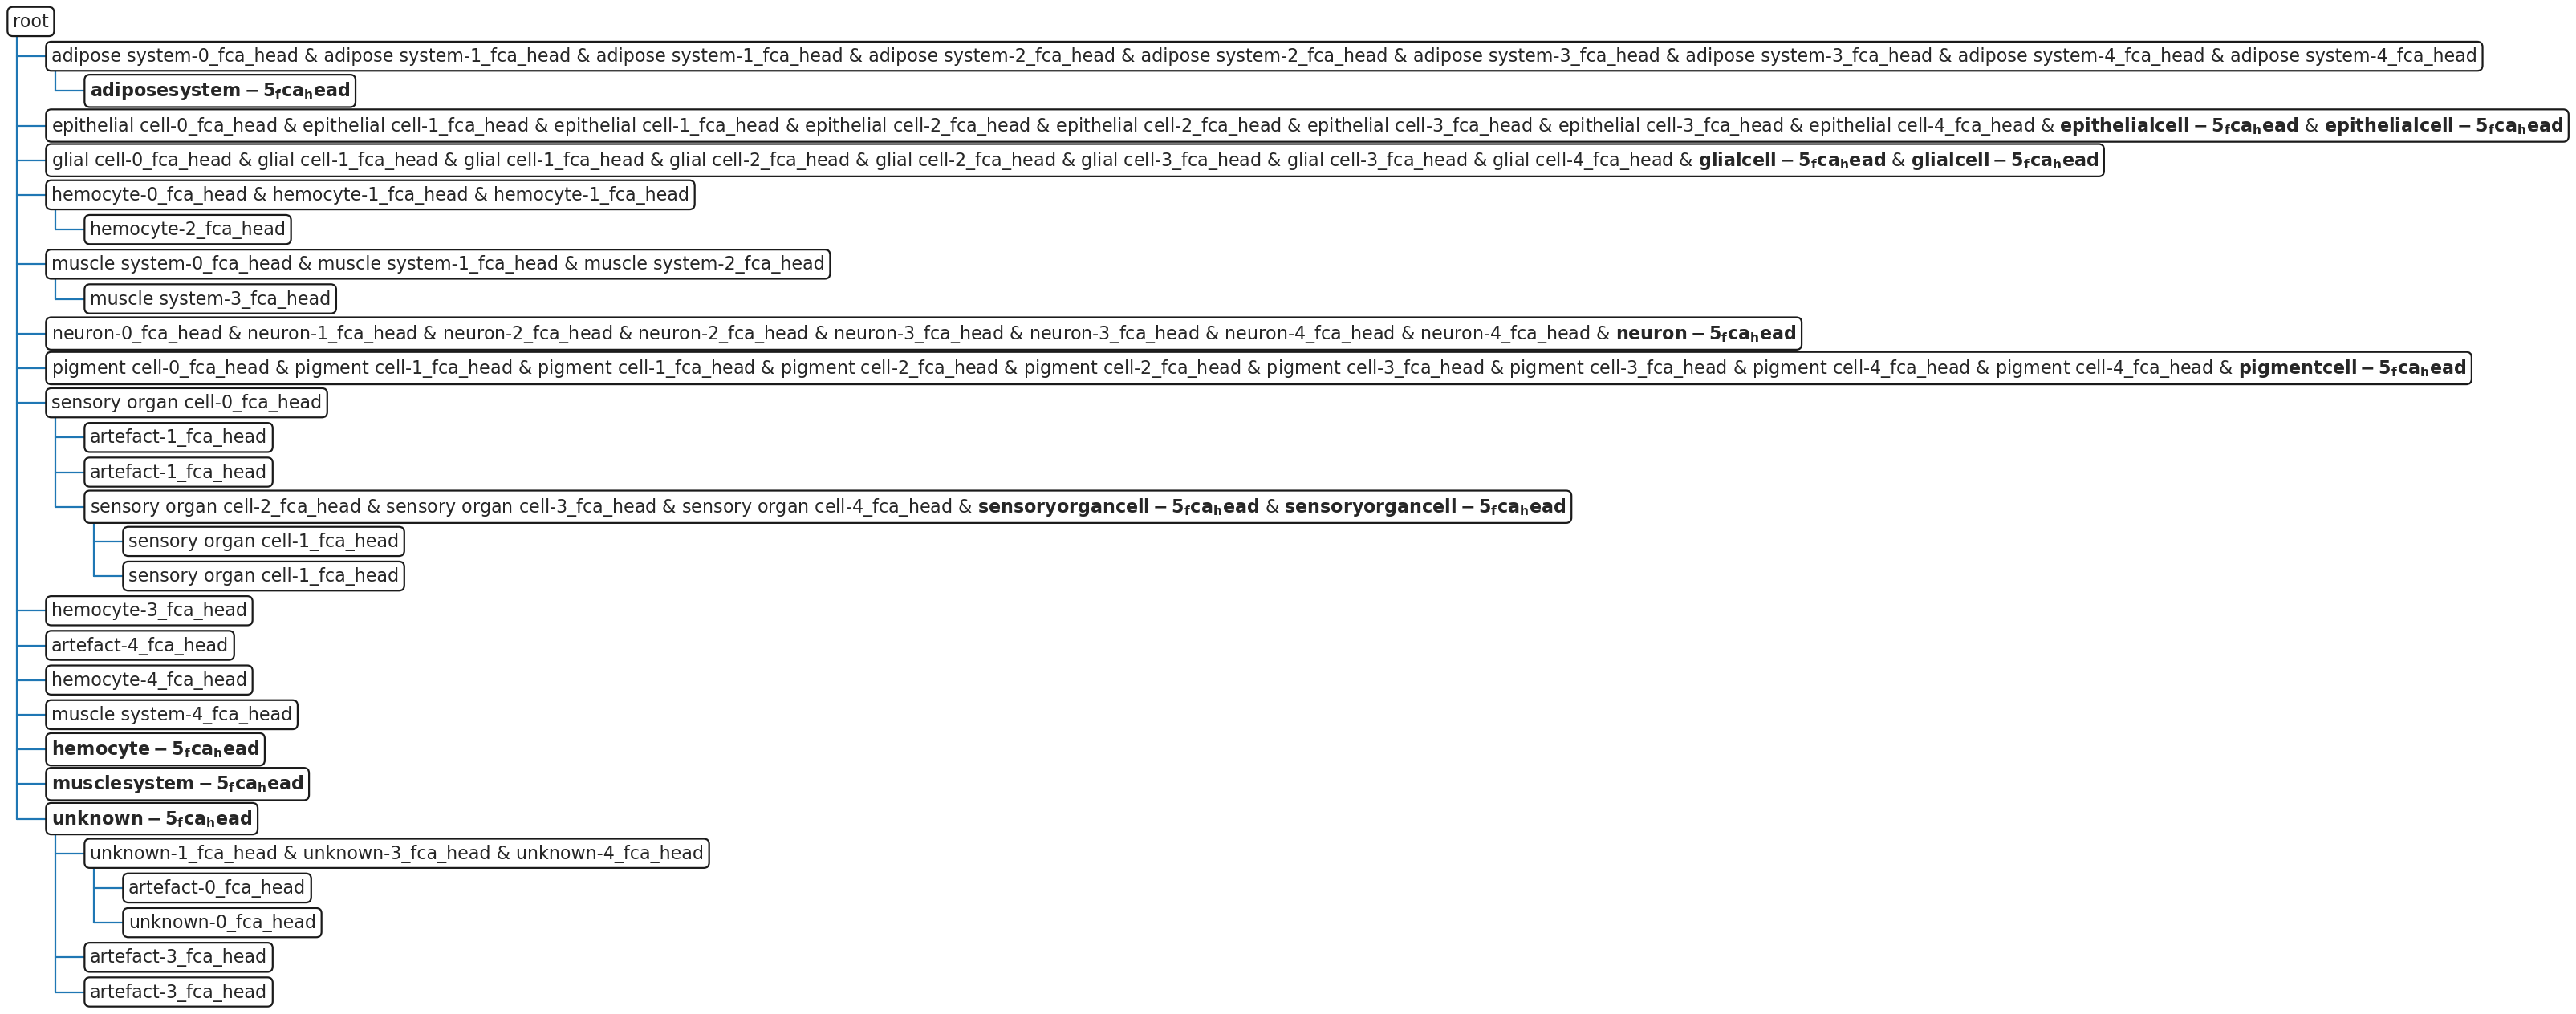


Adding dataset 6_fca_head to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scHPL/update.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
/projectnb/mccall/sbandya/.c


Updated tree:


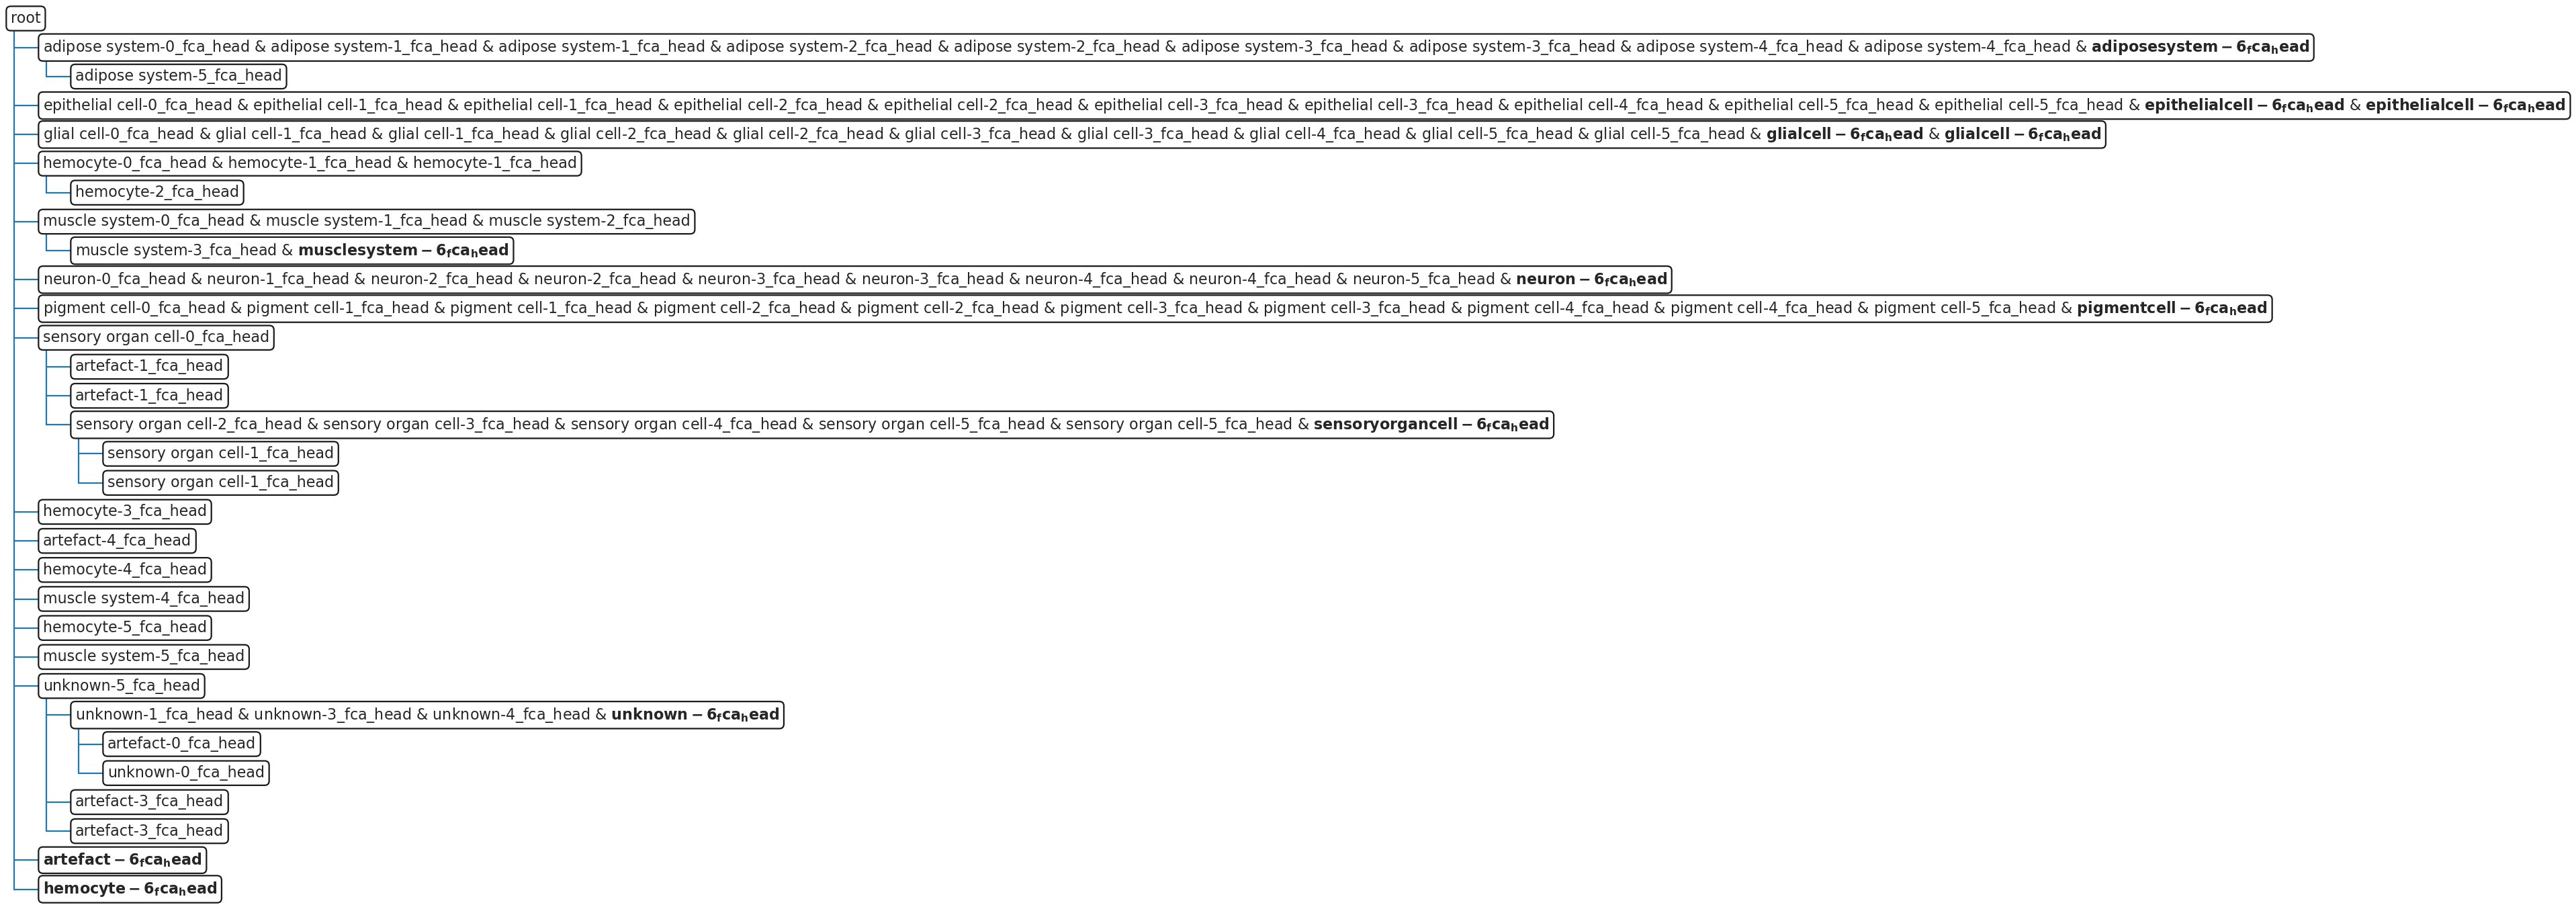


Adding dataset 7_fca_head to the tree


In [19]:
tissue_batchorder = head_latent.obs.tissue_batch.unique().tolist()
tree_head_broadannotation_tissue_batch, mp_head_broadannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='broad_annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tree_head_fullannotation_tissue_batch, mp_head_fullannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
## Write tree hierarchy as pickle file
## Tissue only 
with open(head_model+'tree_head_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_head_broadannotation_tissue, f)
f.close()

with open(head_model+'mp_head_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_head_broadannotation_tissue, f) 
f.close()


with open(head_model+'tree_head_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_head_fullannotation_tissue, f)
f.close()

with open(head_model+'mp_head_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_head_fullannotation_tissue, f) 
f.close()

## Tissue & batch 
with open(head_model+'tree_head_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_head_broadannotation_tissue_batch, f)
f.close()

with open(head_model+'mp_head_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_head_broadannotation_tissue_batch, f) 
f.close()


with open(head_model+'tree_head_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_head_fullannotation_tissue_batch, f)
f.close()

with open(head_model+'mp_head_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_head_fullannotation_tissue_batch, f) 
f.close()

## Integrate the antenna reference with the pretrained head model

In [ ]:
fca_reference_antenna = fca_reference_antenna[:,fca_reference_head.var_names]
fca_reference_antenna

In [ ]:
fca_reference_antenna = fca_reference_antenna.copy()
head_antenna_vae = sca.models.SCVI.load_query_data(
    fca_reference_antenna,
    head_model,
    freeze_dropout = True,
)

In [ ]:
head_antenna_vae.train(max_epochs=200, check_val_every_n_epoch = 1)

In [ ]:
history_df = (
    head_antenna_vae.history['elbo_train'].astype(float)
    .join(head_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head, antenna combined VAE model")
    + p.theme_minimal()
)


print(p_)

In [ ]:
head_antenna_latent = sc.AnnData(head_antenna_vae.get_latent_representation())
head_antenna_latent.obs["batch"] = fca_reference_antenna.obs["batch"].tolist()
head_antenna_latent.obs["tissue"] = fca_reference_antenna.obs["tissue"].tolist()
head_antenna_latent.obs["tissue_batch"] = fca_reference_antenna.obs["tissue_batch"].tolist()
head_antenna_latent.obs["annotation"] = fca_reference_antenna.obs["annotation"].tolist()
head_antenna_latent.obs["broad_annotation"] = fca_reference_antenna.obs["broad_annotation"].tolist()
head_antenna_latent.obs["broad_annotation_extrapolated"] = fca_reference_antenna.obs["broad_annotation_extrapolated"].tolist()


In [ ]:
head_antenna_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_antenna_model/"
head_antenna_vae.save(head_antenna_model, overwrite=True)
head_antenna_latent.write(head_antenna_model+'reference_latent.h5ad')

In [ ]:
fca_reference_combined = fca_reference_head.concatenate(fca_reference_antenna, batch_key="head_antenna")
fca_reference_combined

In [ ]:
combined_latent = sc.AnnData(head_antenna_vae.get_latent_representation(adata=fca_reference_combined))
combined_latent.obs["tissue"] = fca_reference_combined.obs["tissue"].tolist()
combined_latent.obs["batch"] = fca_reference_combined.obs["batch"].tolist()
combined_latent.obs["tissue_batch"] = fca_reference_combined.obs["tissue_batch"].tolist()
combined_latent.obs["annotation"] = fca_reference_combined.obs["annotation"].tolist()
combined_latent.obs["broad_annotation"] = fca_reference_combined.obs["broad_annotation"].tolist()
combined_latent.obs["broad_annotation_extrapolated"] = fca_reference_combined.obs["broad_annotation_extrapolated"].tolist()

combined_latent

In [ ]:
combined_latent.obs

In [ ]:
sc.pp.neighbors(combined_latent)
sc.tl.leiden(combined_latent)
sc.tl.umap(combined_latent)

In [ ]:
sc.pl.umap(combined_latent,
           color=['tissue','tissue_batch'],
           frameon=False,
           wspace=0.6, s=25,
           #palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           #save='study_query.pdf'
           )

In [ ]:
sc.pl.umap(combined_latent,
           color=['broad_annotation'],
           frameon=False,
           wspace=0.6, s=25,
           #palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           #save='study_query.pdf'
           )

In [ ]:
for s in np.unique(combined_latent.obs.tissue):
    ref_s = cp.deepcopy(combined_latent)
    ref_s.obs.broad_annotation[combined_latent.obs.tissue != s] = np.nan

    sc.pl.umap(ref_s,
               color=['broad_annotation'],
               frameon=False,
               wspace=0.6, s=60,
               #palette=sns.color_palette('colorblind', as_cmap=True), title=s,
               #save=s+'_query.pdf'
               )

## Update tree hierarchy with antenna labels

In [ ]:
combined_latent.obs['broad_annotation_tissue'] = np.char.add(np.char.add(np.array(combined_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue'], dtype=str))
combined_latent.obs['annotation_tissue'] = np.char.add(np.char.add(np.array(combined_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue'], dtype=str))

combined_latent.obs['broad_annotation_tissue_batch'] = np.char.add(np.char.add(np.array(combined_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue_batch'], dtype=str))
combined_latent.obs['annotation_tissue_batch'] = np.char.add(np.char.add(np.array(combined_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue_batch'], dtype=str))

In [ ]:
combined_latent.obs['broad_annotation_tissue'] = combined_latent.obs['broad_annotation_tissue'].astype('category')
combined_latent.obs['annotation_tissue'] = combined_latent.obs['annotation_tissue'].astype('category')
combined_latent.obs['broad_annotation_tissue_batch'] = combined_latent.obs['broad_annotation_tissue_batch'].astype('category')
combined_latent.obs['annotation_tissue_batch'] = combined_latent.obs['annotation_tissue_batch'].astype('category')

In [ ]:
# First make a deep copy of the original classifier to ensure we do not overwrite it
tree_combined_broadannotation_tissue = cp.deepcopy(tree_head_broadannotation_tissue)
tree_combined_broadannotation_tissue_batch = cp.deepcopy(tree_head_broadannotation_tissue_batch)
tree_combined_fullannotation_tissue = cp.deepcopy(tree_head_fullannotation_tissue)
tree_combined_fullannotation_tissue_batch = cp.deepcopy(tree_head_fullannotation_tissue)

In [ ]:
tree_combined_broadannotation_tissue, mp_combined_broadannotation_tissue = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue',
                batch_order = fca_reference_antenna.obs.tissue.unique().tolist(),
                batch_added = fca_reference_head.obs.tissue.unique().tolist(),
                cell_type_key='broad_annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,
                tree = tree_combined_broadannotation_tissue, retrain = False)

In [ ]:
tree_combined_fullannotation_tissue, mp_combined_fullannotation_tissue = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue',
                batch_order = fca_reference_antenna.obs.tissue.unique().tolist(),
                batch_added = fca_reference_head.obs.tissue.unique().tolist(),
                cell_type_key='annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,
                tree = tree_combined_fullannotation_tissue, retrain = False)

In [ ]:
tree_combined_broadannotation_tissue_batch, mp_combined_broadannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue_batch',
                batch_order = fca_reference_antenna.obs.tissue_batch.unique().tolist(),
                batch_added = fca_reference_head.obs.tissue_batch.unique().tolist(),
                cell_type_key='broad_annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,
                tree = tree_combined_broadannotation_tissue_batch, retrain = False)

In [ ]:
tree_combined_fullannotation_tissue_batch, mp_combined_fullannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue_batch',
                batch_order = fca_reference_antenna.obs.tissue_batch.unique().tolist(),
                batch_added = fca_reference_head.obs.tissue_batch.unique().tolist(),
                cell_type_key='annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,
                tree = tree_combined_fullannotation_tissue_batch, retrain = False)

In [ ]:
## Write tree hierarchy as pickle file
## Tissue only
with open(head_antenna_model+'tree_combined_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_combined_broadannotation_tissue, f)
f.close()

with open(head_antenna_model+'mp_combined_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_combined_broadannotation_tissue, f) 
f.close()

with open(head_antenna_model+'tree_combined_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_combined_fullannotation_tissue, f)
f.close()

with open(head_antenna_model+'mp_combined_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_combined_fullannotation_tissue, f) 
f.close()

## Tissue & batch combined 

with open(head_antenna_model+'tree_combined_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_combined_broadannotation_tissue_batch, f)
f.close()

with open(head_antenna_model+'mp_combined_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_combined_broadannotation_tissue_batch, f) 
f.close()

with open(head_antenna_model+'tree_combined_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_combined_fullannotation_tissue_batch, f)
f.close()

with open(head_antenna_model+'mp_combined_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_combined_fullannotation_tissue_batch, f) 
f.close()